In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchsummary import summary

In [4]:
# using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# ensuring reproducibility of code
torch.manual_seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# loading data

batch_size = 128

train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


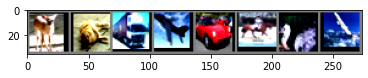

deer cat truck plane car horse bird plane


In [7]:
def imshow(img):
    """
    function to plot images.
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[0:8]

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%s' % classes[labels[j]] for j in range(8)))

In [8]:
class AutoConv2d_BN(nn.Module):
    """
    custom block that implements 'same' padding for a convolution followed by 
    batch normalisation
    """
    def __init__(self, input_channels, output_channels, kernel_size, stride = 1):
        super(AutoConv2d_BN, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, 
                              kernel_size = kernel_size, 
                              padding = kernel_size // 2, stride = stride)
        self.bn = nn.BatchNorm2d(output_channels, momentum = 0.2)
    
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

In [9]:
class VanillaResBlock(nn.Module):
    """
    simple residual block with 2 `AutoConv2d_BN` layers and a shortcut mapping
    """
    def __init__(self, input_channels, output_channels, kernel_size):
        super(VanillaResBlock, self).__init__()
        self.conv = AutoConv2d_BN(input_channels, output_channels, 
                                  kernel_size = kernel_size)

    def forward(self, x):
        input = x
        x = F.relu(self.conv(x))
        x = self.conv(x)
        x = F.relu(x + input)
        return x

In [10]:
class BottleneckResBlock(nn.Module):
    """
    bottleneck residual block to reduce compute in the deeper layers
    """
    def __init__(self, input_channels, bottleneck_channels, output_channels, kernel_size):
        super(BottleneckResBlock, self).__init__()
        self.conv1 = AutoConv2d_BN(input_channels, bottleneck_channels, 
                                   kernel_size = 1)
        self.conv2 = AutoConv2d_BN(bottleneck_channels, bottleneck_channels, 
                                   kernel_size = kernel_size)
        self.conv3 = AutoConv2d_BN(bottleneck_channels, output_channels, 
                                   kernel_size = 1)

    def forward(self, x):
        input = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = F.relu(x + input)
        return x

In [11]:
class DownsampleResBlock(nn.Module):
    """
    simple residual block with downsampling of images
    """
    def __init__(self, input_channels, output_channels, kernel_size, down_stride):
        super(DownsampleResBlock, self).__init__()
        self.conv1 = AutoConv2d_BN(input_channels, output_channels, 
                                   kernel_size = kernel_size, stride = down_stride)
        self.conv2 = AutoConv2d_BN(output_channels, output_channels, 
                                   kernel_size)
        self.conv3 = AutoConv2d_BN(input_channels, output_channels, 
                                   kernel_size = 1, stride = down_stride)

    def forward(self, x):
        input = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = F.relu(x + self.conv3(input))
        return x

In [12]:
class DownbottleResBlock(nn.Module):
    """
    bottleneck block that downsamples images
    """
    def __init__(self, input_channels, bottleneck_channels , output_channels, kernel_size, down_stride):
        super(DownbottleResBlock, self).__init__()
        self.conv1 = AutoConv2d_BN(input_channels, bottleneck_channels, 
                                   kernel_size = 1)
        self.conv2 = AutoConv2d_BN(bottleneck_channels, bottleneck_channels, 
                                   kernel_size = kernel_size, stride = down_stride)
        self.conv3 = AutoConv2d_BN(bottleneck_channels, output_channels, 
                                   kernel_size = 1)
        self.conv4 = AutoConv2d_BN(input_channels, output_channels, 
                                   kernel_size = 1, stride = down_stride)

    def forward(self, x):
        input = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = F.relu(x + self.conv4(input))
        return x

In [13]:
class ResNetlike(nn.Module):
    """
    returns ResNet-like neural network architecture.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.block1 = VanillaResBlock(32, 32, 3)
        self.block2 = VanillaResBlock(32, 32, 3)
        self.block3 = DownsampleResBlock(32, 64, 3, 2)
        self.block4 = BottleneckResBlock(64, 16, 64, 3)
        self.block5 = BottleneckResBlock(64, 16, 64, 3)
        self.block6 = DownbottleResBlock(64, 32, 128, 3, 2)
        self.block7 = BottleneckResBlock(128, 32, 128, 3)
        self.block8 = BottleneckResBlock(128, 32, 128, 3)
        self.block9 = DownbottleResBlock(128, 64, 256, 3, 2)
        self.gap = nn.AvgPool2d((4, 4))
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [14]:
# moving net to GPU
net = ResNetlike()
net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 32, 28, 28]           9,248
       BatchNorm2d-4           [-1, 32, 28, 28]              64
     AutoConv2d_BN-5           [-1, 32, 28, 28]               0
            Conv2d-6           [-1, 32, 28, 28]           9,248
       BatchNorm2d-7           [-1, 32, 28, 28]              64
     AutoConv2d_BN-8           [-1, 32, 28, 28]               0
   VanillaResBlock-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 32, 28, 28]           9,248
      BatchNorm2d-11           [-1, 32, 28, 28]              64
    AutoConv2d_BN-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           9,248
      BatchNorm2d-14           [-1, 32,

In [ ]:
# defining loss, optimizer and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = 3e-3, weight_decay = 0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [50, 75])

In [ ]:
def train(epoch):
    running_loss = 0.0
    train_total = 0
    train_correct = 0

    for child in net.children():
        for layer in child.modules():
            if(isinstance(layer, torch.nn.modules.batchnorm.BatchNorm2d)):
                layer.track_running_stats = True


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        running_loss += loss.item()
        predicted = torch.argmax(outputs.data, dim = 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    scheduler.step()

    # print statistics
    train_accuracy = 100 * (train_correct / train_total)
    print("Epoch", epoch + 1)
    print(f'    Loss of the network on the {train_total} training images: {running_loss}')
    print(f'    Accuracy of the network on the {train_total} training images: {train_accuracy}%')


In [ ]:
def test():
    # test set evaluation
    test_correct = 0
    test_total = 0

    # since we're not training, we don't need to calculate the gradients

    with torch.no_grad():
        for child in net.children():
            for layer in child.modules():
                if(isinstance(layer, torch.nn.modules.batchnorm.BatchNorm2d)):
                    layer.track_running_stats = False

        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs.data, dim = 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * (test_correct / test_total)
    print(f'    Accuracy of the network on the {test_total} test images: {test_accuracy}%')

In [ ]:
# training loop

epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    train(epoch)
    test()

print('Finished Training')

Epoch 1
    Loss of the network on the 50000 training images: 621.1989550590515
    Accuracy of the network on the 50000 training images: 40.516000000000005%
    Accuracy of the network on the 10000 test images: 51.43%
Epoch 2
    Loss of the network on the 50000 training images: 458.4296921491623
    Accuracy of the network on the 50000 training images: 57.46%
    Accuracy of the network on the 10000 test images: 63.61%
Epoch 3
    Loss of the network on the 50000 training images: 384.1015735268593
    Accuracy of the network on the 50000 training images: 64.864%
    Accuracy of the network on the 10000 test images: 66.31%
Epoch 4
    Loss of the network on the 50000 training images: 335.3035531640053
    Accuracy of the network on the 50000 training images: 69.796%
    Accuracy of the network on the 10000 test images: 71.89%
Epoch 5
    Loss of the network on the 50000 training images: 303.2965199351311
    Accuracy of the network on the 50000 training images: 72.85000000000001%
    

In [ ]:
# saving weights of model
model_save_name = 'cifarresnetlike.pt'
path = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/{model_save_name}" 
torch.save(net, path)

In [16]:
# loading model
model_save_name = 'cifarresnetlike.pt'
PATH = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/{model_save_name}"
model = torch.load(PATH, map_location=torch.device(device))

In [17]:
# moving model to GPU
model.to(device);

In [18]:
for child in model.children():
  for layer in child.modules():
    if(isinstance(layer, torch.nn.modules.batchnorm.BatchNorm2d)):
        layer.track_running_stats = False

In [19]:
# evaluating on test set

dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.to(device)

output = model(images)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}')

Accuracy of the network on the 10000 test images: 89.33
